In [1]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [8]:
print(df['product_name'].isnull().sum())
print(df['product_name'].str.len().min())


0
13


In [11]:
print(df['product_name'].sample(5))


86446    SET227 SET227-KR-PP-A-XL
40238        NW034 NW034-TP-PJ-XL
65395        J0231 J0231-SKD-XXXL
21665            J0220 J0220-BL-S
10868       JNE3622 JNE3622-KR-XL
Name: product_name, dtype: object


In [6]:
!python -m nltk.downloader punkt


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
!python -m nltk.downloader stopwords


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<ipython-input-14-ca6f97ca1323>:14: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Amazon_Sale_Reportt.csv")
<ipython-input-14-ca6f97ca1323>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['Date'])


Top Trending Topics:
    year  month  topic  product_name  trend_score
7   2022      4      0         31316          1.0
8   2022      4      1         14328          1.0
9   2022      4      2          1937          1.0
12  2022      4      5           236          1.0
13  2022      4      6           150          1.0
15  2022      4      8            61          1.0
16  2022      4      9            32          1.0
20  2022      5      3           804          1.0
21  2022      5      4           715          1.0
24  2022      5      7            90          1.0


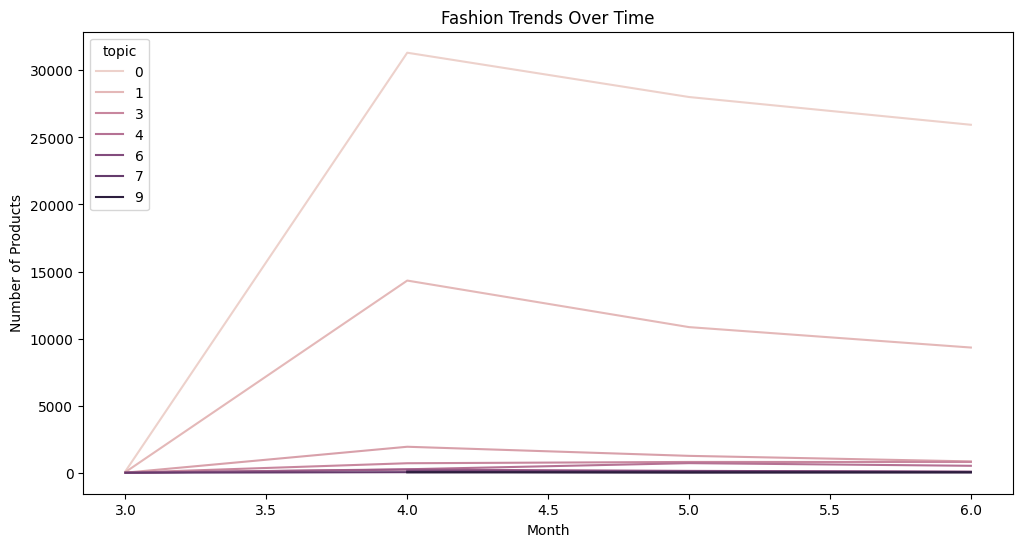

In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from datetime import datetime

# Load the dataset
df = pd.read_csv("Amazon_Sale_Reportt.csv")

# Preprocess the data
df['date'] = pd.to_datetime(df['Date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Extract relevant features
df['product_name'] = df['Style'] + ' ' + df['SKU']
df['category'] = df['Category']
df['size'] = df['Size']

# Text preprocessing
import re

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Extract the descriptive part of the product name
    match = re.search(r'([a-zA-Z\s]+)', text)
    if match:
        text = match.group(1)
    else:
        return ''

    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # Remove stop words
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]

    return ' '.join(tokens)

df['processed_text'] = df['product_name'].apply(preprocess_text)


# Fit the NMF model
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = tfidf.fit_transform(df['processed_text'])
nmf = NMF(n_components=10, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# Assign topic numbers to each row
topic_nums = np.argmax(W, axis=1)
df['topic'] = topic_nums

# Identify trending topics
topic_counts = df.groupby(['year', 'month', 'topic'])['product_name'].count().reset_index()
topic_counts['topic'] = topic_counts['topic'].astype(int)
topic_counts['trend_score'] = topic_counts.groupby(['topic'])['product_name'].rank(method='dense', ascending=False)


# Find the top trending topics
top_trends = topic_counts[topic_counts['trend_score'] == 1]
print("Top Trending Topics:")
print(top_trends)

# Visualize trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='product_name', hue='topic', data=topic_counts)
plt.title('Fashion Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Products')
plt.show()
